# Infer ***ER*** - part 8️⃣

--------------

OBJECTIVE:  ✅ Infer sub-cellular component ***ER*** (***ER***) in order to understand interactome 



Dependencies:
The ***ER***  inference rely on the cytoplasm mask.



## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys

import numpy as np

from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_3d,  
                                                         edge_preserving_smoothing_3d )
from aicssegmentation.core.utils import topology_preserving_thinning, size_filter
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.vessel import filament_2d_wrapper
                                                 
from skimage.measure import label


import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                                                    read_ome_image,
                                                                    export_inferred_organelle,
                                                                    import_inferred_organelle,
                                                                    list_image_files)

from infer_subc.core.img import *

from infer_subc.organelles import get_cellmask, get_nuclei, get_cytoplasm


%load_ext autoreload
%autoreload 2



In [2]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )              


## SETUP

In [3]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [4]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## GET CYTOSOL MASK

> note: don't actually need it here, but getting for testing and visualization purposes.


In [5]:

###################
# SOMA, NUCLEI, CYTOSOL, NUCLEUS
###################
nuclei_obj =  get_nuclei(img_data,meta_dict, out_data_path)
soma_obj = get_cellmask(img_data, nuclei_obj, meta_dict, out_data_path)
cytoplasm_mask = get_cytoplasm(nuclei_obj , soma_obj , meta_dict, out_data_path)



>>>>>>>>>>>> tifffile.imread  (dtype=uint8in (0.01) sec
loaded  inferred 3D `nuclei`  from /Users/ahenrie/Projects/Imaging/data/out 
>>>>>>>>>>>> tifffile.imread  (dtype=int32in (0.03) sec
loaded  inferred 3D `cellmask`  from /Users/ahenrie/Projects/Imaging/data/out 
>>>>>>>>>>>> tifffile.imread  (dtype=uint8in (0.01) sec
loaded  inferred 3D `cytoplasm`  from /Users/ahenrie/Projects/Imaging/data/out 


---------------------

## infer ***ER***

## summary of steps 

INPUT
- ch 6
- cytoplasm mask

PRE-PROCESSING
- edge preserving scaling

CORE-PROCESSING
- vesselness slice-by-slice

POST-PROCESSING
  - S  - remove objects less than 2x2 pixels (area = 4)

OUTPUT
- object **er** 


Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

>sec61beta  is  good start for ER  as per from [Allen Cell](https://www.allencell.org/cell-observations/category/endoplasmic-reticulum).    

using [seg_sec61b.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aics-segmentation/aicssegmentation/structure_wrapper/seg_sec61b.py)
[seg_sec61b_dual.py](https://github.com/AllenInstitute/aics-segmentation/blob/master/aicssegmentation/structure_wrapper/seg_sec61b_dual.py)

[playground_Sec61b.ipynb](https://github.com/AllenInstitute/aics-segmentation/blob/master/lookup_table_demo/playground_Sec61b.ipynb)



## INPUT prototype

In [6]:
###################
# INPUT
###################
# raw_ER   = img_2D[ER_CH].copy()
raw_ER = select_channel_from_raw(img_data, ER_CH)


## PRE-PROCESSING prototype

In [32]:
###################
# PRE_PROCESSING
###################
# struct_img = normalized_edge_preserving_smoothing( raw_ER)

median_sz = 3
gauss_sig = 2.0

struct_img =  scale_and_smooth(raw_ER,
                                                    median_sz = median_sz, 
                                                    gauss_sig = gauss_sig)


## CORE PROCESSING prototype

In [33]:
###################
# CORE_PROCESSING
###################

################################
## PARAMETERS for this step ##
f2_param = [[1, 0.015]]
################################

bw = filament_2d_wrapper(struct_img, f2_param)

## POST-PROCESSING prototype

In [34]:

###################
# POST_PROCESSING
###################
################################
## PARAMETERS for this step ##
small_object_width = 4
################################
er_object = size_filter_linear_size(bw, 
                                                min_size= small_object_width)

# ################################
# ## PARAMETERS for this step ## from seg_sec61b.py
# min_area = 15
# ################################
# bw = remove_small_objects(bw > 0, min_size=min_area, connectivity=1, in_place=False)
# # prune slice by slice
# for zz in range(bw.shape[0]):
#     bw[zz, :, :] = remove_small_objects(bw[zz, :, :], min_size=3, connectivity=1, in_place=False)

# ER_object = remove_small_objects(bw > 0, min_size=min_area, connectivity=1, in_place=False)



#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [15]:
viewer = napari.Viewer()


In [35]:

viewer.add_image(
    bw,
)


viewer.scale_bar.visible = True
viewer.add_image(
    struct_img
)

viewer.add_image(
    er_object,
)

<Image layer 'er_object [5]' at 0x1762bd730>

## DEFINE `infer_ER` function

Based on the _prototyping_ above define the function to infer the er.  


In [47]:
##########################
#  infer_ER
##########################
def _infer_ER(
                                in_img: np.ndarray,
                                median_sz: int,
                                gauss_sig: float,
                                filament_scale : float,
                                filament_cut : float,
                                small_obj_w: int,
                            ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    filament_scale: 
        scale (log_sigma) for filament filter
    filament_cut: 
        threshold for filament fitered threshold
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    er_ch = ER_CH
    ###################
    # EXTRACT
    ###################    
    er = select_channel_from_raw(in_img, er_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    # er = normalized_edge_preserving_smoothing(er)
    struct_img =  scale_and_smooth(er,
                                                    median_sz = median_sz, 
                                                    gauss_sig = gauss_sig)

   ###################
    # CORE_PROCESSING
    ###################
    # f2_param = [[filament_scale, filament_cut]]
    # # f2_param = [[1, 0.15]]  # [scale_1, cutoff_1]
    # struct_obj = filament_2d_wrapper(er, f2_param)
    struct_obj = filament_filter(struct_img, filament_scale, filament_cut)

    ###################
    # POST_PROCESSING
    ################### 
    struct_obj = size_filter_linear_size(struct_obj, 
                                                    min_size= small_obj_w)

    return label_uint16(struct_obj)



# TEST  `_fixed_infer_ER` function

In [39]:
##########################
#  fixed_infer_ER
##########################
def _fixed_infer_ER(in_img: np.ndarray ) -> np.ndarray:
    """
    Procedure to infer endoplasmic rediculum from linearly unmixed input with *fixed parameters*

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels

    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    median_sz = 3
    gauss_sig = 2.
    filament_scale = 1
    filament_cut = 0.015
    small_obj_w = 2 
    return _infer_ER(  in_img,
                                median_sz,
                                gauss_sig,
                                filament_scale,
                                filament_cut ,
                                small_obj_w)
    
    

# TEST  `_infer_ER` function

In [48]:

_ER_object =  _fixed_infer_ER(img_data) 


In [49]:
from infer_subc.organelles import fixed_infer_ER

er_object =  fixed_infer_ER(img_data) 


## Visualize  2


In [50]:

viewer.add_image(
    er_object,
)
viewer.add_labels(
    label(er_object),
)


viewer.add_image(
    _ER_object,
)

<Image layer '_ER_object' at 0x176551eb0>

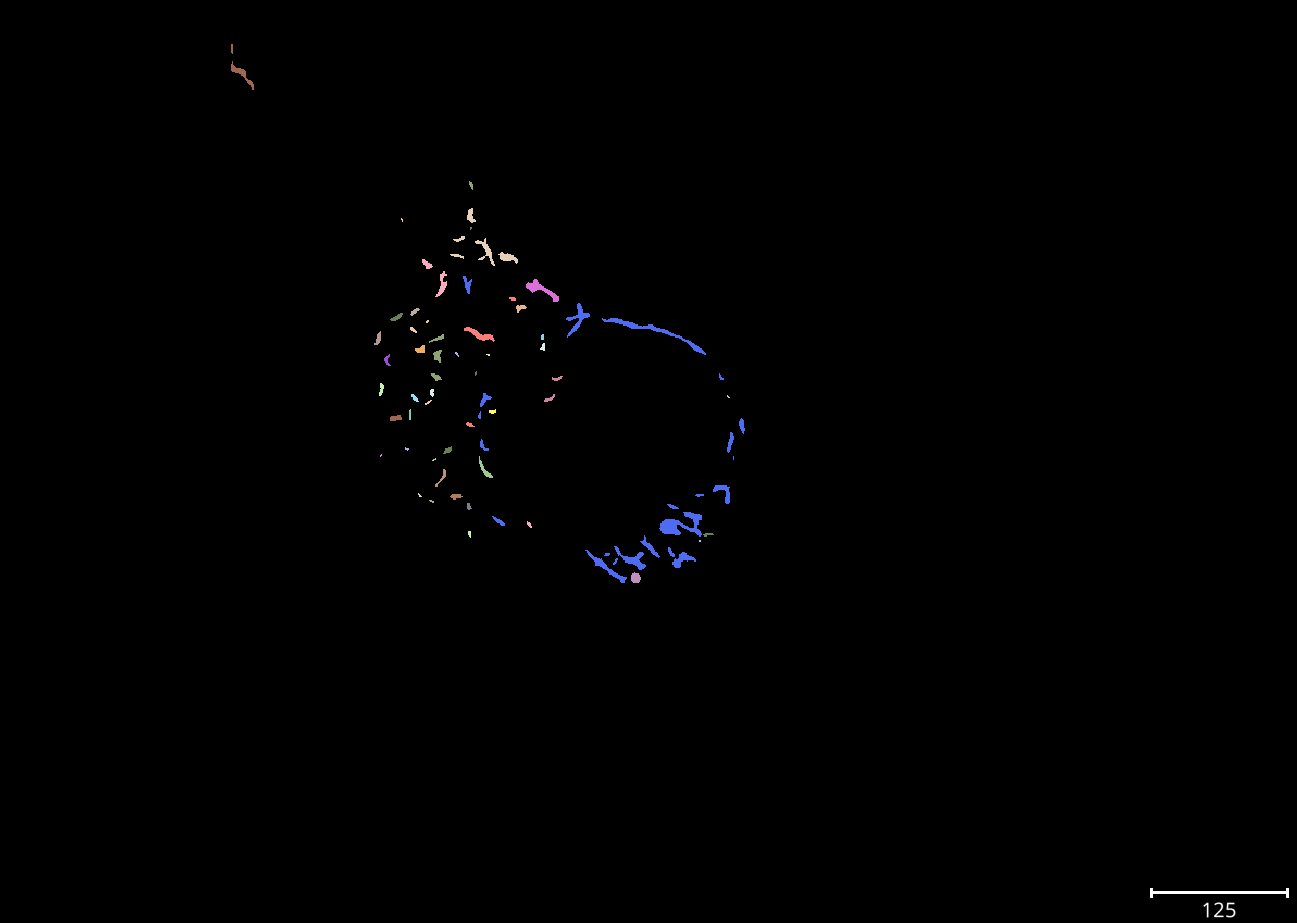

In [51]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [52]:
viewer.close()

-------------
## SUMMARY

The above details how the ER object is inferred.  

### NEXT: INFER LIPID BODY

proceed to [09_infer_lipid_droplet.ipynb](./09_infer_lipid_droplet.ipynb)
